# Prática 7

Aprendizado Dinâmico

por Cibele Russo (ICMC/USP - São Carlos SP)

MBA em Ciências de Dados



**1.Faça a leitura das bibliotecas.**

Nesta prática vamos considerar redes dinâmicas para modelar a temperatura global dos dados em globaltemp.

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

**2. Leia os dados do arquivo globaltemp.csv.**

<AxesSubplot:xlabel='year'>

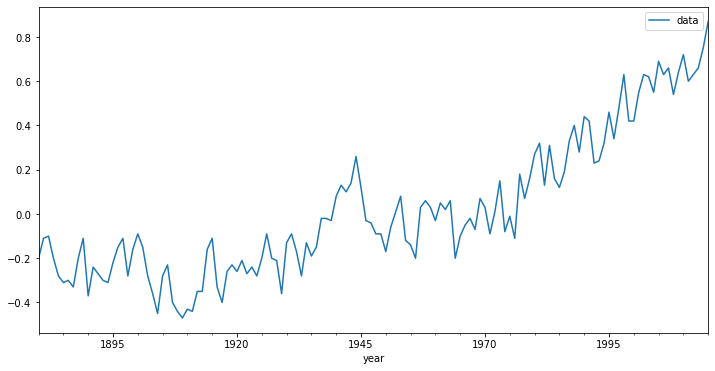

In [4]:
# Temperatura global

# Diferenças na média de temperatura global. 
# Fonte: https://github.com/mjuez/pytsdatasets/

pkgdir = '/hdd/MBA/AprendizadoDinamico/Data'


df = pd.read_csv('globaltemp.csv', index_col=0,
                         parse_dates=True)
df.index = df.index
df.plot(figsize=(12,6))


In [5]:
df.head()

,data
year,
1880-01-01,-0.20
1881-01-01,-0.11
1882-01-01,-0.10
1883-01-01,-0.20
1884-01-01,-0.28


##

**3.  Divida a base em treino e teste, deixando 14 dias para a previsão.**

In [ ]:
len(df)

In [ ]:
len(df)-14


In [6]:
train = df.iloc[:122]
test = df.iloc[122:]

In [7]:
train

,data
year,
1880-01-01,-0.20
1881-01-01,-0.11
1882-01-01,-0.10
1883-01-01,-0.20
1884-01-01,-0.28
...,...
1997-01-01,0.48
1998-01-01,0.63
1999-01-01,0.42


**4. Padronize os dados para a modelagem.**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

**5. Considere o gerador de séries temporais, com variados valores para os parâmetros length e batch_size.**


In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# defina o gerador
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
len(scaled_train)

In [ ]:
len(generator) # n_input = 2

In [ ]:
# Qual é a aparência do primeiro lote?
X,y = generator[0]

In [ ]:
print(f'Dado o array: \n{X.flatten()}');
print(f'Previsão: \n {y}');

**6. Carregue as bibliotecas do keras para as redes dinâmicas.**

In [ ]:
### Pacote ideal do tensorflow = 2.5
### Pacote ideal do keras = 2.6
### Caso necessário, instale o pacote nessas versões

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

**7. Defina os lotes pra o processo iterativo.**

In [ ]:
# Vamos redefinir lotes de tamanho 21 para o procedimento iterativo
# Veja mais informações sobre o tamanho do lote http://deeplearningbook.com.br/o-efeito-do-batch-size-no-treinamento-de-redes-neurais-artificiais/

n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

**8. Defina o modelo. Ele pode ter uma camada LSTM e uma camada Dense. Teste alternativas.**

In [ ]:
# Defina o modelo
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

**9. Faça o ajuste do modelo e observe a função de perda.**

In [ ]:
# Ajuste do modelo

model.fit_generator(generator,epochs=100)

In [ ]:
model.history.history.keys()

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

**10. Faça a previsão.**

In [ ]:
# Vejamos passo a passo como é feita a previsão, a princípio para a próxima observação usando o tamanho do lote igual a 7

first_eval_batch = scaled_train[-7:]

In [ ]:
first_eval_batch

In [ ]:
# Agora vamos considerar as previsões para as próximas 21 observações e comparar com a base de teste

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model.predict(current_batch)[0]
    
    # predição
    test_predictions.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

In [ ]:
scaled_test

**11. Retorne da padronização.**

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions

In [ ]:
# Possivelmente encontraremos warnings aqui
test['Predictions'] = true_predictions

**12. Visualize os resultados, comparando as previsões com a base de teste.**

In [ ]:

test.plot(figsize=(12,8))